In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### Bivariate Normal Data Generation

In [4]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 1],
    2: [3, 5],
    3: [2, 4]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

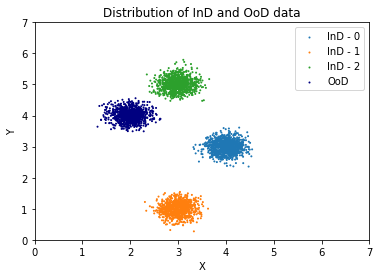

In [565]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

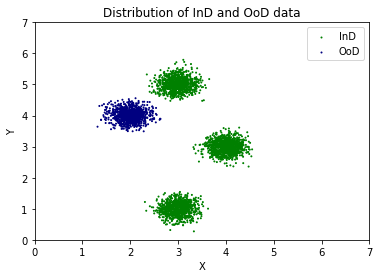

In [566]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [567]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  1%|          | 3/256 [00:00<00:20, 12.46it/s]

Epoch  # 1 | Tri loss: 1.149                     | Tri accuracy: 0.3323
Epoch  # 1 | Val loss: 1.1383                     | Val accuracy: 0.3341


 21%|██        | 53/256 [00:02<00:08, 23.83it/s]

Epoch  # 51 | Tri loss: 0.0343                     | Tri accuracy: 0.9997
Epoch  # 51 | Val loss: 0.0334                     | Val accuracy: 1.0


 41%|████      | 104/256 [00:04<00:06, 23.19it/s]

Epoch  # 101 | Tri loss: 0.0057                     | Tri accuracy: 0.9997
Epoch  # 101 | Val loss: 0.0057                     | Val accuracy: 1.0


 61%|██████    | 155/256 [00:07<00:04, 24.28it/s]

Epoch  # 151 | Tri loss: 0.0023                     | Tri accuracy: 1.0
Epoch  # 151 | Val loss: 0.0024                     | Val accuracy: 1.0


 79%|███████▉  | 203/256 [00:09<00:02, 22.71it/s]

Epoch  # 201 | Tri loss: 0.0013                     | Tri accuracy: 1.0
Epoch  # 201 | Val loss: 0.0013                     | Val accuracy: 1.0


 99%|█████████▉| 254/256 [00:11<00:00, 23.12it/s]

Epoch  # 251 | Tri loss: 0.0008                     | Tri accuracy: 1.0
Epoch  # 251 | Val loss: 0.0008                     | Val accuracy: 1.0


100%|██████████| 256/256 [00:11<00:00, 22.05it/s]


#### Plot

torch.Size([10000, 3])


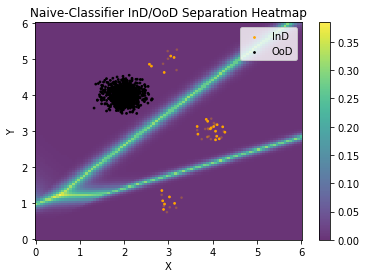

In [568]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="Naive-Classifier", m=100)

### WOOD Training

In [32]:
cri = torch.nn.NLLLoss()
a = torch.tensor([[0.99, 0.01]])
a = a.log()
print(cri(a, torch.tensor([1])))

tensor(4.6052)


In [11]:
from simulation import *
D_WOOD = DSIM(16)
# OOD data preparation
n_ood = 2
ood_bsz = 8
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([2, 2])


  1%|          | 1/128 [00:00<00:40,  3.10it/s]

Epoch  # 1 | Tri loss: 1.1165                     | Tri accuracy: 0.3095
Epoch  # 1 | Val loss: 1.1033                     | Val accuracy: 0.3348


  9%|▊         | 11/128 [00:03<00:37,  3.11it/s]

Epoch  # 11 | Tri loss: 0.4942                     | Tri accuracy: 1.0
Epoch  # 11 | Val loss: 0.4749                     | Val accuracy: 1.0


 16%|█▋        | 21/128 [00:06<00:30,  3.49it/s]

Epoch  # 21 | Tri loss: 0.1253                     | Tri accuracy: 1.0
Epoch  # 21 | Val loss: 0.1258                     | Val accuracy: 1.0


 24%|██▍       | 31/128 [00:09<00:29,  3.28it/s]

Epoch  # 31 | Tri loss: 0.0436                     | Tri accuracy: 1.0
Epoch  # 31 | Val loss: 0.051                     | Val accuracy: 1.0


 32%|███▏      | 41/128 [00:12<00:28,  3.00it/s]

Epoch  # 41 | Tri loss: 0.0115                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.0367                     | Val accuracy: 1.0


 40%|███▉      | 51/128 [00:16<00:27,  2.84it/s]

Epoch  # 51 | Tri loss: -0.0067                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0185                     | Val accuracy: 1.0


 48%|████▊     | 61/128 [00:19<00:19,  3.41it/s]

Epoch  # 61 | Tri loss: -0.0124                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.0127                     | Val accuracy: 1.0


 55%|█████▌    | 71/128 [00:22<00:17,  3.22it/s]

Epoch  # 71 | Tri loss: -0.0149                     | Tri accuracy: 1.0
Epoch  # 71 | Val loss: 0.0095                     | Val accuracy: 1.0


 63%|██████▎   | 81/128 [00:25<00:14,  3.26it/s]

Epoch  # 81 | Tri loss: -0.0169                     | Tri accuracy: 1.0
Epoch  # 81 | Val loss: 0.0082                     | Val accuracy: 1.0


 71%|███████   | 91/128 [00:28<00:10,  3.48it/s]

Epoch  # 91 | Tri loss: -0.0182                     | Tri accuracy: 1.0
Epoch  # 91 | Val loss: 0.007                     | Val accuracy: 1.0


 79%|███████▉  | 101/128 [00:31<00:07,  3.54it/s]

Epoch  # 101 | Tri loss: -0.019                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.006                     | Val accuracy: 1.0


 87%|████████▋ | 111/128 [00:34<00:04,  3.60it/s]

Epoch  # 111 | Tri loss: -0.0195                     | Tri accuracy: 1.0
Epoch  # 111 | Val loss: 0.0054                     | Val accuracy: 1.0


 95%|█████████▍| 121/128 [00:36<00:01,  3.55it/s]

Epoch  # 121 | Tri loss: -0.0202                     | Tri accuracy: 1.0
Epoch  # 121 | Val loss: 0.0056                     | Val accuracy: 1.0


100%|██████████| 128/128 [00:38<00:00,  3.29it/s]


In [13]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 1.0
0.99: 0.9980000257492065
0.999: 0.9789999723434448


0.012695903788321737

### OOD GAN Training

In [30]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(64)
G_GAN = GSIM(64)
# OOD data preparation
# n_ood = 64
ood_bsz = 8
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-4
w_ce, w_wass, w_dist = 1, 0.1, 0.1
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([2, 2])


  0%|          | 0/128 [00:00<?, ?it/s]

Step: 0    | D:  1.0401 | CE:  1.0681 | W_OoD:  0.3103 | W_z:  0.3099 | G: -0.0031 | W_z:  0.3092 | dist: 2.9105
Step: 10   | D:  1.0296 | CE:  1.0588 | W_OoD:  0.3228 | W_z:  0.3085 | G: -0.0031 | W_z:  0.3086 | dist: 2.6209


  1%|          | 1/128 [00:40<1:26:07, 40.69s/it]

Epoch  # 1 | Val accuracy: 0.3328
Step: 8    | D:  0.9962 | CE:  1.0267 | W_OoD:  0.3355 | W_z:  0.3089 | G: -0.0031 | W_z:  0.3090 | dist: 2.3579


  2%|▏         | 2/128 [01:20<1:24:39, 40.32s/it]

Step: 6    | D:  0.9466 | CE:  0.9783 | W_OoD:  0.3479 | W_z:  0.3124 | G: -0.0031 | W_z:  0.3124 | dist: 2.0566


  2%|▏         | 3/128 [02:00<1:23:39, 40.16s/it]

Step: 4    | D:  0.9273 | CE:  0.9591 | W_OoD:  0.3499 | W_z:  0.3204 | G: -0.0032 | W_z:  0.3215 | dist: 1.7159


  3%|▎         | 4/128 [02:40<1:22:36, 39.97s/it]

Step: 2    | D:  0.9098 | CE:  0.9413 | W_OoD:  0.3474 | W_z:  0.3290 | G: -0.0033 | W_z:  0.3303 | dist: 1.4014


  4%|▍         | 5/128 [03:20<1:22:09, 40.08s/it]

Step: 0    | D:  0.8957 | CE:  0.9266 | W_OoD:  0.3436 | W_z:  0.3477 | G: -0.0035 | W_z:  0.3492 | dist: 1.3751
Step: 10   | D:  0.8745 | CE:  0.9051 | W_OoD:  0.3407 | W_z:  0.3487 | G: -0.0035 | W_z:  0.3486 | dist: 1.4618


  5%|▍         | 6/128 [03:59<1:20:47, 39.74s/it]

Epoch  # 6 | Val accuracy: 0.6668
Step: 8    | D:  0.8581 | CE:  0.8877 | W_OoD:  0.3305 | W_z:  0.3473 | G: -0.0035 | W_z:  0.3467 | dist: 1.5377


  5%|▌         | 7/128 [04:39<1:20:23, 39.87s/it]

Step: 6    | D:  0.8317 | CE:  0.8606 | W_OoD:  0.3240 | W_z:  0.3458 | G: -0.0035 | W_z:  0.3456 | dist: 1.5328


  6%|▋         | 8/128 [05:18<1:18:59, 39.49s/it]

Step: 4    | D:  0.8185 | CE:  0.8471 | W_OoD:  0.3203 | W_z:  0.3429 | G: -0.0034 | W_z:  0.3426 | dist: 1.5409


  7%|▋         | 9/128 [06:00<1:19:50, 40.25s/it]

Step: 2    | D:  0.8081 | CE:  0.8363 | W_OoD:  0.3164 | W_z:  0.3401 | G: -0.0034 | W_z:  0.3398 | dist: 1.5423


  8%|▊         | 10/128 [06:39<1:18:34, 39.96s/it]

Step: 0    | D:  0.7831 | CE:  0.8110 | W_OoD:  0.3126 | W_z:  0.3378 | G: -0.0034 | W_z:  0.3376 | dist: 1.5627
Step: 10   | D:  0.7745 | CE:  0.8018 | W_OoD:  0.3069 | W_z:  0.3356 | G: -0.0034 | W_z:  0.3354 | dist: 1.5445


  9%|▊         | 11/128 [07:16<1:15:54, 38.93s/it]

Epoch  # 11 | Val accuracy: 0.8288
Step: 8    | D:  0.7626 | CE:  0.7896 | W_OoD:  0.3025 | W_z:  0.3335 | G: -0.0033 | W_z:  0.3333 | dist: 1.5368


  9%|▉         | 12/128 [07:52<1:13:50, 38.20s/it]

Step: 6    | D:  0.7398 | CE:  0.7664 | W_OoD:  0.2989 | W_z:  0.3311 | G: -0.0033 | W_z:  0.3312 | dist: 1.5332


 10%|█         | 13/128 [08:29<1:12:09, 37.65s/it]

Step: 4    | D:  0.7320 | CE:  0.7581 | W_OoD:  0.2947 | W_z:  0.3294 | G: -0.0033 | W_z:  0.3294 | dist: 1.5322


 11%|█         | 14/128 [09:05<1:10:47, 37.26s/it]

Step: 2    | D:  0.7153 | CE:  0.7411 | W_OoD:  0.2902 | W_z:  0.3281 | G: -0.0033 | W_z:  0.3278 | dist: 1.5148


 12%|█▏        | 15/128 [09:41<1:09:35, 36.95s/it]

Step: 0    | D:  0.6999 | CE:  0.7254 | W_OoD:  0.2869 | W_z:  0.3263 | G: -0.0033 | W_z:  0.3263 | dist: 1.5021
Step: 10   | D:  0.6924 | CE:  0.7173 | W_OoD:  0.2818 | W_z:  0.3252 | G: -0.0033 | W_z:  0.3251 | dist: 1.5062


 12%|█▎        | 16/128 [10:18<1:08:45, 36.84s/it]

Epoch  # 16 | Val accuracy: 0.9926
Step: 8    | D:  0.6731 | CE:  0.6974 | W_OoD:  0.2754 | W_z:  0.3238 | G: -0.0032 | W_z:  0.3237 | dist: 1.4864


 13%|█▎        | 17/128 [10:54<1:07:56, 36.73s/it]

Step: 6    | D:  0.6574 | CE:  0.6814 | W_OoD:  0.2713 | W_z:  0.3227 | G: -0.0032 | W_z:  0.3227 | dist: 1.4304


 14%|█▍        | 18/128 [11:31<1:07:27, 36.80s/it]

Step: 4    | D:  0.6335 | CE:  0.6572 | W_OoD:  0.2687 | W_z:  0.3216 | G: -0.0032 | W_z:  0.3214 | dist: 1.3679


 15%|█▍        | 19/128 [12:09<1:07:11, 36.99s/it]

Step: 2    | D:  0.6252 | CE:  0.6486 | W_OoD:  0.2660 | W_z:  0.3208 | G: -0.0032 | W_z:  0.3207 | dist: 1.3063


 16%|█▌        | 20/128 [12:45<1:06:09, 36.75s/it]

Step: 0    | D:  0.6155 | CE:  0.6385 | W_OoD:  0.2618 | W_z:  0.3201 | G: -0.0032 | W_z:  0.3200 | dist: 1.2292
Step: 10   | D:  0.6002 | CE:  0.6229 | W_OoD:  0.2586 | W_z:  0.3191 | G: -0.0032 | W_z:  0.3192 | dist: 1.1628


 16%|█▋        | 21/128 [13:22<1:05:29, 36.73s/it]

Epoch  # 21 | Val accuracy: 0.999
Step: 8    | D:  0.5856 | CE:  0.6080 | W_OoD:  0.2557 | W_z:  0.3186 | G: -0.0032 | W_z:  0.3185 | dist: 1.0835


 17%|█▋        | 22/128 [13:58<1:04:40, 36.61s/it]

Step: 6    | D:  0.5792 | CE:  0.6011 | W_OoD:  0.2516 | W_z:  0.3181 | G: -0.0032 | W_z:  0.3181 | dist: 1.0197


 18%|█▊        | 23/128 [14:35<1:04:00, 36.57s/it]

Step: 4    | D:  0.5748 | CE:  0.5965 | W_OoD:  0.2489 | W_z:  0.3175 | G: -0.0032 | W_z:  0.3169 | dist: 0.9647


 19%|█▉        | 24/128 [15:14<1:04:54, 37.45s/it]

Step: 2    | D:  0.5504 | CE:  0.5718 | W_OoD:  0.2457 | W_z:  0.3167 | G: -0.0032 | W_z:  0.3168 | dist: 0.9119


 20%|█▉        | 25/128 [15:54<1:05:46, 38.31s/it]

Step: 0    | D:  0.5401 | CE:  0.5613 | W_OoD:  0.2436 | W_z:  0.3156 | G: -0.0032 | W_z:  0.3156 | dist: 0.8764
Step: 10   | D:  0.5340 | CE:  0.5549 | W_OoD:  0.2409 | W_z:  0.3150 | G: -0.0032 | W_z:  0.3155 | dist: 0.8410


 20%|██        | 26/128 [16:33<1:05:12, 38.36s/it]

Epoch  # 26 | Val accuracy: 1.0
Step: 8    | D:  0.5265 | CE:  0.5473 | W_OoD:  0.2394 | W_z:  0.3150 | G: -0.0032 | W_z:  0.3151 | dist: 0.7657


 21%|██        | 27/128 [17:14<1:05:58, 39.20s/it]

Step: 6    | D:  0.5049 | CE:  0.5253 | W_OoD:  0.2350 | W_z:  0.3157 | G: -0.0032 | W_z:  0.3157 | dist: 0.7082


 22%|██▏       | 28/128 [17:55<1:06:21, 39.81s/it]

Step: 4    | D:  0.4931 | CE:  0.5132 | W_OoD:  0.2324 | W_z:  0.3157 | G: -0.0032 | W_z:  0.3158 | dist: 0.6332


 23%|██▎       | 29/128 [18:40<1:08:21, 41.43s/it]

Step: 2    | D:  0.4805 | CE:  0.5003 | W_OoD:  0.2299 | W_z:  0.3155 | G: -0.0032 | W_z:  0.3157 | dist: 0.6428


 23%|██▎       | 30/128 [19:21<1:07:00, 41.03s/it]

Step: 0    | D:  0.4782 | CE:  0.4977 | W_OoD:  0.2264 | W_z:  0.3153 | G: -0.0032 | W_z:  0.3153 | dist: 0.6485
Step: 10   | D:  0.4623 | CE:  0.4813 | W_OoD:  0.2218 | W_z:  0.3151 | G: -0.0032 | W_z:  0.3151 | dist: 0.6520


 24%|██▍       | 31/128 [20:01<1:05:57, 40.80s/it]

Epoch  # 31 | Val accuracy: 1.0
Step: 8    | D:  0.4498 | CE:  0.4686 | W_OoD:  0.2188 | W_z:  0.3146 | G: -0.0031 | W_z:  0.3145 | dist: 0.6282


 25%|██▌       | 32/128 [20:41<1:04:59, 40.62s/it]

Step: 6    | D:  0.4451 | CE:  0.4635 | W_OoD:  0.2151 | W_z:  0.3146 | G: -0.0031 | W_z:  0.3145 | dist: 0.6107


 26%|██▌       | 33/128 [21:21<1:03:59, 40.42s/it]

Step: 4    | D:  0.4303 | CE:  0.4489 | W_OoD:  0.2171 | W_z:  0.3139 | G: -0.0031 | W_z:  0.3136 | dist: 0.5586


 27%|██▋       | 34/128 [22:01<1:03:15, 40.38s/it]

Step: 2    | D:  0.4378 | CE:  0.4561 | W_OoD:  0.2150 | W_z:  0.3132 | G: -0.0031 | W_z:  0.3131 | dist: 0.5356


 27%|██▋       | 35/128 [22:42<1:02:37, 40.41s/it]

Step: 0    | D:  0.4222 | CE:  0.4401 | W_OoD:  0.2099 | W_z:  0.3139 | G: -0.0031 | W_z:  0.3134 | dist: 0.4946


### Plot

#### Plot Naive Classifier

In [593]:
m, n_ind, n_ood = 300, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([90000, 3])


In [594]:
threshold =calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold

0.99: 0.007000000216066837


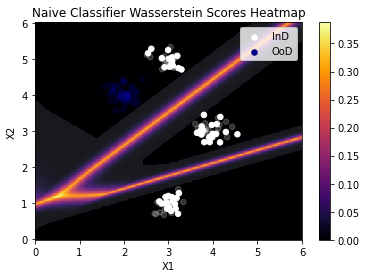

In [595]:
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
n_ind, n_ood = 50, 50, 
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"Naive Classifier Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_naive.jpg", dpi=1000)

#### Plot WOOD

In [571]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


0.99: 1.0


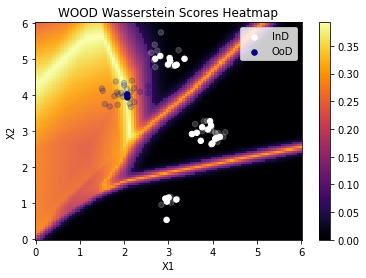

In [572]:
threshold =calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"WOOD Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_wood.jpg", dpi=1000)

#### Plot GAN

In [19]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi_gan = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi_gan.shape)
si_gan = ood_wass_loss(zi_gan)

torch.Size([10000, 3])


In [20]:
threshold =calculate_accuracy(D=D_GAN, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si_gan > threshold

0.99: 0.0020000000949949026


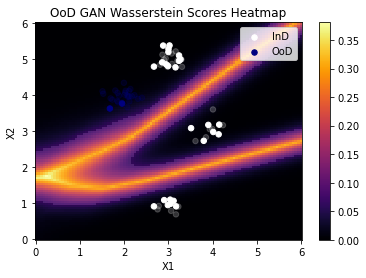

In [21]:
# plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
plt.pcolormesh(xi, yi, si_gan.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"OoD GAN Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example.jpg", dpi=1000)

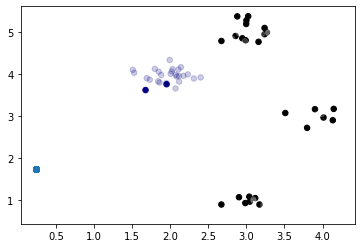

In [25]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Save

In [556]:
torch.save(D, "simulation_log/example/D.pt")
torch.save(D_WOOD, "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN, "simulation_log/example/D_GAN.pt")
torch.save(G_GAN, "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')